In [35]:
from WindPy import w
import pandas as pd
import numpy as np
import os
import shutil
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.api import het_white, het_breuschpagan
from statsmodels.stats.sandwich_covariance import cov_hac
from statsmodels.tsa.seasonal import STL
from matplotlib.font_manager import FontProperties 
matplotlib.pyplot.rcParams['font.sans-serif']=['simhei']
font_path = '/Users/miaxiaozile/Library/Fonts/SimHei.ttf'
font_prop = FontProperties(fname=font_path)
matplotlib.rcParams['axes.unicode_minus']=False

In [2]:
w.start()

2024-07-05 15:39:32.417 Python[4137:132333] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


Wind.Cosmos.Base V1.7 compiled time is Apr 17 2023, BuildType:Release, CPUArch:X64, GCC Version:Apple LLVM 13.0.0 (clang-1300.0.29.30)
Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2021 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [3]:
start_date = "2009-12-01" # actually from 2010, extract data for preprocessing
end_date = "2024-05-31"

In [24]:
# takes a dict of indicators and their corresponding ticker in Wind to
# create a DataFrame containing the data extracted from Wind API
def extract_inds(inds):
    df = pd.DataFrame()
    for ind in inds:
        raw = w.edb(inds[ind], start_date, end_date, Period="M")
        # Extract data from the Wind API response
        times = raw.Times
        data = raw.Data[0]
        # Convert times to pandas datetime format
        times = pd.to_datetime([str(time) for time in times], format="%Y-%m-%d")
        
        # Create a temporary DataFrame for the current indicator
        temp_df = pd.DataFrame(data, index=times, columns=[ind])
        
        # Combine the temporary DataFrame with the main DataFrame
        if df.empty:
            df = temp_df
        else:
            df = df.join(temp_df, how='outer')
    return df

In [29]:
def apply_x11(df, columns, x13as_path='/usr/local/bin/x13as'):
    tempdir = os.path.join(os.getcwd(), 'x13as_temp')
    os.makedirs(tempdir, exist_ok=True)

    df_adjusted = df.copy()
    for column in columns:
        ts = df[column].asfreq('M')
        
        # Handle zero or negative values
        min_value = ts.min()
        shift_value = abs(min_value) + 1 if min_value <= 0 else 0
        ts_shifted = ts + shift_value

        try:
            result = sm.tsa.x13_arima_analysis(ts_shifted, x12path=x13as_path, tempdir=tempdir)
            if result is None:
                raise ValueError(f"X-13ARIMA-SEATS returned None for column: {column}")
            
            # Adjust the seasonally adjusted data back
            df_adjusted[column] = result.seasadj - shift_value
            print(f"Successfully processed column: {column}")
            
        except Exception as e:
            print(f"Error processing column {column}: {e}")
            
            # Read and print the .err file for more details
            err_file_path = os.path.join(tempdir, 'x13as.err')
            if os.path.exists(err_file_path):
                with open(err_file_path, 'r') as err_file:
                    print(f"Error file content for column {column}:")
                    print(err_file.read())
            continue
    
    # Cleanup temporary directory
    shutil.rmtree(tempdir)

    return df_adjusted

# Example usage
# df = pd.read_csv('your_file.csv')
# df_adjusted = apply_x11(df, df.columns)

In [6]:
def lag_data(df, periods=1):
    df_lagged = df.shift(periods)
    df_lagged = df_lagged.iloc[periods:]  # Remove the first rows
    return df_lagged

In [41]:
# consider key growth indicators for China
china_growth_inds = {
    # production method
    # general macro indicators
    'GDP(%)': 'M0039354',
    'Industrial_Added_Value_(%)': 'M0000545',
    'PMI': 'M0017126',
    'Manufacturing_PMI': 'M0017127',
    'Manufacturing_PMI:New_Orders': 'M0017128',
    # by industry
    'Electricity_Production(%)': 'S0027013',
    'Output:Cement(%)': 'S0027703',
    'Output:Crude_Steel(%)': 'S0027375',
    'Output:Motor_Vehicles(%)': 'S0027908',
    'Railway_Freight_Traffic(%)': 'S0036034',
    # expenditure method
    # investments
    'FAI(%)': 'M0000273',
    'Completed_Investment_in_Real_Estate_Development(%)': 'S0029657',
    'FAI:Infrastructure_Investment(%)': 'M5440435',
    'FAI:Manufacturing(%)': 'M0000357',
    # consumption
    'Total_Retail_Sales_of_Consumer_Goods(%)': 'M0001428',
    'Sales:Vehicle(%)': 'S6114593',
    'Sales:Excavators(%)': 'S6002167',
    'Floor_Space_of_Commercial_Buildings_Sold(%)': 'S0073300',
    'Total_Sales_of_Commercial_Buildings(%)': 'S0049591',
    # net exports
    'Imports_and_Exports(%)': 'M0000605',
    'Exports(%)': 'M0000607',
    'Imports(%)': 'M0000609',
    'Exports_USA(%)': 'M0008499',
    # income method
    'Govt_Revenue(%)': 'M0046169',
    'Industrial_Enterprise:Total_Profits(%)': 'M0000557'
}
# for standardizing the PMI data
china_nonyoy_cols = ['PMI', 'Manufacturing_PMI', 'Manufacturing_PMI:New_Orders']

In [25]:
# actual step retrieving data from Wind API
df_china_growth = extract_inds(china_growth_inds)
df_china_growth = lag_data(df_china_growth)  # lag data by 1 period
df_china_growth = df_china_growth.interpolate(method="linear", limit_direction="both")  # interpolate missing values


In [26]:
df_china_growth

,GDP(%),Industrial_Added_Value_(%),PMI,Manufacturing_PMI,Manufacturing_PMI:New_Orders,Electricity_Production(%),Output:Cement(%),Output:Crude_Steel(%),Output:Motor_Vehicles(%),Railway_Freight_Traffic(%),...,Sales:Vehicle(%),Sales:Excavators(%),Floor_Space_of_Commercial_Buildings_Sold(%),Total_Sales_of_Commercial_Buildings(%),Imports_and_Exports(%),Exports(%),Imports(%),Exports_USA(%),Govt_Revenue(%),Industrial_Enterprise:Total_Profits(%)
2010-01-31,11.900000,18.5,56.6,61.4,61.0,25.900000,12.600000,26.600000,130.5000,18.400000,...,90.62,136.73,42.10,75.50,32.760000,17.730000,55.940000,-12.5,11.70,119.690000
2010-02-28,12.000000,29.2,55.8,60.5,59.9,36.462500,49.024000,28.339900,144.3037,18.000000,...,126.15,251.07,40.15,72.85,44.530000,21.000000,85.960000,8.4,41.20,119.690000
2010-03-31,12.100000,12.8,52.0,54.3,53.7,7.900000,4.800000,22.500000,46.7000,17.200000,...,46.40,2.43,38.20,70.20,45.360000,45.630000,45.070000,20.9,32.90,119.690000
2010-04-30,12.200000,18.1,55.1,58.4,58.1,17.600000,12.100000,22.500000,51.5000,17.400000,...,56.36,126.32,35.80,57.70,42.860000,24.210000,66.270000,19.7,34.00,107.006667
2010-05-31,11.733333,17.8,55.7,59.1,59.3,21.400000,16.100000,27.000000,34.6000,14.100000,...,34.87,103.44,32.80,55.40,39.430000,30.380000,49.960000,19.6,34.10,94.323333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-31,5.200000,6.8,49.0,50.2,48.7,7.961700,-0.900000,-14.900000,24.5000,3.663684,...,23.48,-1.01,-8.50,-6.50,1.339957,2.147524,0.287854,-13.1,6.40,-2.300000
2024-02-29,5.233333,26.3,49.2,51.3,49.0,6.241133,-7.933333,-12.533333,18.5000,6.350000,...,47.93,18.50,-14.50,-17.90,10.900000,7.900000,15.400000,-1.8,2.05,3.950000
2024-03-31,5.266667,-12.7,49.1,49.8,49.0,4.520567,-14.966667,-10.166667,12.5000,-5.400000,...,-19.87,-41.20,-20.50,-29.30,-1.200000,5.400000,-8.100000,5.0,-2.30,10.200000
2024-04-30,5.300000,4.5,50.8,52.2,53.0,2.800000,-22.000000,-7.800000,6.5000,-1.477265,...,9.93,-2.34,-19.40,-27.60,-5.200000,-7.600000,-1.900000,-1.3,-2.30,4.300000


In [30]:
df_adjusted = apply_x11(df_china_growth, df_china_growth.columns[1:])
df_adjusted

Successfully processed column: Industrial_Added_Value_(%)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)


Successfully processed column: PMI
Successfully processed column: Manufacturing_PMI
Successfully processed column: Manufacturing_PMI:New_Orders


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant seasonal peak has been found
          in the estimated spectrum of the regARIMA residuals.
  
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)


Successfully processed column: Electricity_Production(%)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant seasonal peak has been found
          in the estimated spectrum of the regARIMA residuals.
  warn(errors, X13Warning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant seasonal peak has been found
          in the estimated spectrum of the regARIMA residuals.
  warn(errors, X13Warning)


Successfully processed column: Output:Cement(%)
Successfully processed column: Output:Crude_Steel(%)
Successfully processed column: Output:Motor_Vehicles(%)
Successfully processed column: Railway_Freight_Traffic(%)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant seasonal peak has been found
          in the estimated spectrum of the regARIMA residuals.
  warn(errors, X13Warning)


Successfully processed column: FAI(%)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)


Successfully processed column: Completed_Investment_in_Real_Estate_Development(%)
Successfully processed column: FAI:Infrastructure_Investment(%)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant seasonal peak has been found
          in the estimated spectrum of the regARIMA residuals.
  warn(errors, X13Warning)


Successfully processed column: FAI:Manufacturing(%)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant seasonal peak has been found
          in the estimated spectrum of the regARIMA residuals.
  warn(errors, X13Warning)


Successfully processed column: Total_Retail_Sales_of_Consumer_Goods(%)
Successfully processed column: Sales:Vehicle(%)
Successfully processed column: Sales:Excavators(%)
Successfully processed column: Floor_Space_of_Commercial_Buildings_Sold(%)
Successfully processed column: Total_Sales_of_Commercial_Buildings(%)
Successfully processed column: Imports_and_Exports(%)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in the estimated spectrum of the regARIMA residuals.
  
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)


Successfully processed column: Exports(%)
Successfully processed column: Imports(%)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)


Successfully processed column: Exports_USA(%)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: The covariance matrix of the ARMA parameters is singular,
          so the standard errors and the correlation matrix of the ARMA
          parameters will not be printed out.
  warn(errors, X13Warning)


Successfully processed column: Govt_Revenue(%)
Successfully processed column: Industrial_Enterprise:Total_Profits(%)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)


,GDP(%),Industrial_Added_Value_(%),PMI,Manufacturing_PMI,Manufacturing_PMI:New_Orders,Electricity_Production(%),Output:Cement(%),Output:Crude_Steel(%),Output:Motor_Vehicles(%),Railway_Freight_Traffic(%),...,Sales:Vehicle(%),Sales:Excavators(%),Floor_Space_of_Commercial_Buildings_Sold(%),Total_Sales_of_Commercial_Buildings(%),Imports_and_Exports(%),Exports(%),Imports(%),Exports_USA(%),Govt_Revenue(%),Industrial_Enterprise:Total_Profits(%)
2010-01-31,11.900000,18.137148,56.627063,60.823266,61.220733,27.221098,10.468042,26.855392,131.859809,18.060936,...,90.347735,148.237471,42.536540,76.287890,34.814844,17.230003,55.157152,-12.856717,12.039450,118.191411
2010-02-28,12.000000,28.945298,56.278695,60.938433,59.998417,35.808014,50.855044,26.952074,146.822903,17.815735,...,127.329779,207.564297,41.549068,73.634181,43.125219,20.666574,89.337262,8.081911,41.045664,117.860093
2010-03-31,12.100000,12.456957,52.612652,55.360180,54.164805,5.576164,8.577586,21.732369,46.340163,17.461999,...,49.088439,-28.542518,39.837340,69.899489,47.322494,39.908728,48.987520,20.690158,32.883219,119.292559
2010-04-30,12.200000,17.610443,54.055312,57.650016,56.792604,16.904620,12.550751,21.811993,50.069592,17.410423,...,53.407758,156.946943,37.112408,59.717467,42.721291,27.074685,63.541598,18.994738,33.281408,107.280837
2010-05-31,11.733333,18.447471,54.876307,58.217050,58.381626,22.901808,14.720090,27.259677,35.125189,14.919164,...,34.259148,119.381954,33.310299,54.974775,39.850467,30.171322,52.445393,19.682117,34.238412,95.638093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-31,5.200000,6.813632,49.154831,50.584871,49.243652,8.021459,-1.819028,-13.644733,21.649257,4.753887,...,22.992766,6.047319,-9.023908,-7.520539,2.609764,3.241562,1.141299,-15.458582,6.629450,-2.955084
2024-02-29,5.233333,26.472076,49.161057,51.359613,50.137749,6.112087,-7.895634,-13.217083,20.052040,7.401001,...,47.346174,9.541015,-15.041271,-17.503509,12.839128,9.234110,12.648009,-1.716213,2.112405,2.384534
2024-03-31,5.266667,-12.529524,49.071395,50.779897,49.618675,4.213090,-16.386537,-12.214869,12.714342,-9.082905,...,-18.516447,-53.635211,-21.607204,-25.926377,-1.642765,3.440133,-9.800487,6.326815,-2.819461,9.307704
2024-04-30,5.300000,4.033643,50.002894,51.730748,51.399186,1.964357,-22.630824,-10.767260,6.402667,-1.544968,...,9.903240,8.104733,-21.818458,-28.655018,-4.795817,-7.044513,-2.598672,-0.926839,-0.895421,5.757187


In [31]:
smoothed_pre = df_china_growth.rolling(window=2).mean()
smoothed_after = df_adjusted.rolling(window=2).mean()

In [ ]:
df_china_growth["Sales:Excavators(%)"]

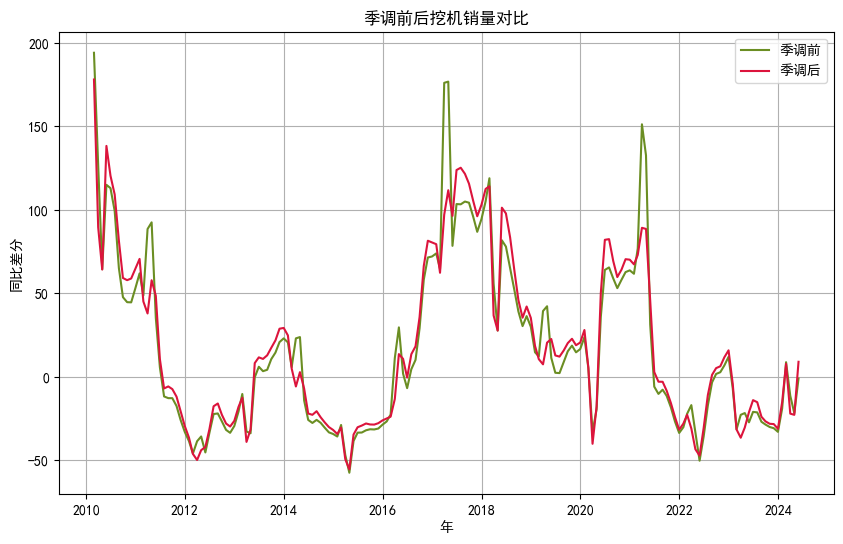

connect And Re login ip:njdxsky.wind.com.cn usPort:443connect And Re login ip:njdxsky.wind.com.cn usPort:8443connect And Re login ip:180.96.8.11 usPort:8443connect And Re login ip:njdxsky.wind.com.cn usPort:443connect And Re login ip:180.96.8.11 usPort:443connect And Re login ip:114.80.154.36 usPort:8443connect And Re login ip:shdxsky.wind.com.cn usPort:443connect And Re login ip:114.80.154.36 usPort:443connect And Re login ip:shdxsky.wind.com.cn usPort:8443connect And Re login ip:hksky.wind.com.cn usPort:8443connect And Re login ip:125.215.147.34 usPort:8443connect And Re login ip:hksky.wind.com.cn usPort:443connect And Re login ip:hksky.wind.com.cn usPort:443connect And Re login ip:hksky.wind.com.cn usPort:8443connect And Re login ip:125.215.147.34 usPort:443connect And Re login ip:125.215.147.34 usPort:443connect And Re login ip:hksky.wind.com.cn usPort:443connect And Re login ip:125.215.147.34 usPort:443connect And Re login ip:hksky.wind.com.cn usPort:443connect And Re login ip:hks

In [42]:

plt.figure(figsize=(10, 6))
plt.plot(df_china_growth.index, smoothed_pre["Sales:Excavators(%)"], label="季调前", color="olivedrab")
plt.plot(df_adjusted.index, smoothed_after["Sales:Excavators(%)"], label="季调后", color="crimson")
plt.xlabel('年')
plt.ylabel('同比差分')
plt.title('季调前后挖机销量对比')
plt.legend()
plt.grid(True)
plt.show()